In [2]:
import sys
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

In [3]:
#-------------------------------------------------------------------------------------------------------------------------------
# Title: Solving the ODE for eta and phi, then plotting the growth rate against wavenumber
#-------------------------------------------------------------------------------------------------------------------------------
# Contents: 
#-------------------------------------------------------------------------------------------------------------------------------

# Section 1.0:   Define a function that will integrate through the domain and return phi_{n+1} 

# Section 2.0:   Define a function that will calculate P and Q in d2phi/dy2 + P(y) dphi/dy + Q(y) phi = 0
# Section 2.1:   Allocate memory to the variables and define the constants in the ODE
# Section 2.2:   Calculate P and Q in the ODE for each profile

# Section 3.0:   Define an ODE solver that will use the previous functions to solve the ODE
# Section 3.1:   Set up the grid in y, allocate memory and define the constants
# Section 3.2:   Set up the values for the wave speed and wave number that we will loop over 
# Section 3.3:   Find P and Q for c_0 (first choice of wave speed) and then integrate to find phi with boundary conditions
# Section 3.3.1: Begin the iteration towards a solution for wavenumber in the outer loop 
# Section 3.3.2: Solving for the first choice of wave speed 
# Section 3.3:   Iterate towards a solution for the ODE over all the wave speed increments
# Section 3.4:   Check for convergence and update the wave speed for the next loop
# Section 3.5:   Update the wavenumber in preperation for the next loop

# Section 4.0:   Plots of the results

# Section 5.0:   Time taken for the code to run



In [4]:
#-------------------------------------------------------------------------------------------------------------------------------
# Section 1.0 : Define a function that will integrate through the domain and return phi_{n+1}  
#-------------------------------------------------------------------------------------------------------------------------------
def INT_REES(phi_nm1 , phi_n,  P_n , Q_n , y_nm1 , y_n , y_np1):      
  import sys
  import numpy as np
  import math
  import cmath
  import matplotlib.pyplot as plt

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# phi_nm1 = phi_{n-1} , phi_n = phi_{n} , P_n = P_{n} , Q_n = Q_{n} , y_nm1 = y_{n-1} , y_n = y_{n} , y_np1 = y_{n+1}
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Finite Difference Scheme

# It is assumed that the grid spacing is uniform

# Using a centered finite difference scheme 
# phi = phi_n                                                          
# d/dy phi = (phi_np1-phi_nm1) / 2(y_np1-y_n)                                
# d^{2}/dy^{2} phi = (phi_np1-2*phi_n+phi_nm1) / (y_np1-y_n)^{2}

# phi_np1 [ 1.0/(y_np1 - y_n)^2 + P_n/(y_np1 - y_nm1) ] +  [ (- 2 phi_n + phi_nm1 )/(y_np1 - y_n)^2  -  P_n phi_nm1/(y_np1 - y_nm1) + Q_n phi_n ] = 0

  dy      = y_np1 - y_n 
  denom   = 1.0 / (dy*dy) + (P_n/(y_np1 - y_nm1))               
  num2    = -(P_n * phi_nm1 / (y_np1 - y_nm1)) + Q_n * phi_n   
  num1    = (-2.0 * phi_n + phi_nm1) / (dy*dy) 
  phi_np1 = - (num1 + num2) / denom
    
#  dy = y_np1 - y_n
#  denom = 1.0/(dy*dy) + 0.5*P_nph/dy + 0.25 * Q_nph
#  P_con = -0.5*P_nph*phi_n/(y_np1 - y_n) + 0.5*P_nmh*(phi_n - phi_nm1)/(y_n - y_nm1)
#  Q_con = 0.25 * Q_nph * phi_n  + 0.25 * Q_nmh * (phi_nm1 + phi_n)
#  phi_con = (-2.0*phi_n + phi_nm1)/(dy*dy)
#  phi_np1 = - (phi_con + P_con + Q_con) / denom 

  return phi_np1

In [12]:
#------------------------------------------------------------------------------------------------------------------------------
# Section 2.0 : Define a function that will calculate P and Q in d2phi/dy2 + P(y) dphi/dy + Q(y) phi = 0
#------------------------------------------------------------------------------------------------------------------------------

# Calculating P and Q
def P_Q_Rees(y, c_n , k):   # y is an array of np.zeros, and k is the wavenumber
  import sys
  import numpy as np
  import math
  import cmath
  import matplotlib.pyplot as plt

#------------------------------------------------------------------------------------------------------------------------------
# Section 2.1 : Allocate memory to the variables and define the constants in the ODE
#------------------------------------------------------------------------------------------------------------------------------
  
  len_y = len(y)  # y=np.zeros( no. of levels + 2 , dtype =np.complex ) , see section 3.1
  
  # Allocate memory for the numpy arrays   
  P      = np.zeros( len_y, dtype =  np.complex )     
  Q      = np.zeros( len_y, dtype =  np.complex )
  Pv     = np.zeros( len_y, dtype =  np.complex )
  Qv     = np.zeros( len_y, dtype =  np.complex )
  f      = np.zeros( len_y, dtype =  np.complex )
  B      = np.zeros( len_y, dtype =  np.complex )
  H      = np.zeros( len_y, dtype =  np.complex )
  dHdy   = np.zeros( len_y, dtype =  np.complex )
  U      = np.zeros( len_y, dtype =  np.complex )
  dUdy   = np.zeros( len_y, dtype =  np.complex )
  HQ     = np.zeros( len_y, dtype =  np.complex )
  dHQdy  = np.zeros( len_y, dtype =  np.complex )
  D      = np.zeros( len_y, dtype =  np.complex )
  dDdy   = np.zeros( len_y, dtype =  np.complex )
  F      = np.zeros( len_y, dtype =  np.complex )
  dFdy   = np.zeros( len_y, dtype =  np.complex )
  G      = np.zeros( len_y, dtype =  np.complex )
  dGdy   = np.zeros( len_y, dtype =  np.complex )
  d2Udy2 = np.zeros( len_y, dtype =  np.complex )

  # Define the constants
  beta   = 2.2*(10**-11)       
  g      = 0.0334              # Reduced gravity
  H0     = 60                  # Average thermocline depth (see Tanaka+Hibiya)
  A0     = -1.0                # Constant for n=0
  A2     = -1.0                # Constant for n=2
  c      = np.sqrt(g*H0)      
  C      = np.sqrt((2*beta/c))  
  #y     = C*x                 # Non-dimensional y
  i      = 3                   # Choose your profile: i = [0 (n=0), 1 (n=2), 2 (Cubic), 3 (Quintic) , 4 (Sinusoidal)]
  Levels = 100                 # Used for the sinusoidal profile so we also define this here

#------------------------------------------------------------------------------------------------------------------------------
# Section 2.2 : Calculate P and Q in the ODE for each profile
#------------------------------------------------------------------------------------------------------------------------------
  for iy in range ( len_y ) :
         if i == 0:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            H[iy]     = A0 * np.exp(-B[iy])                                                     
            dHdy[iy]  = - (A0 / 2.0) * C * y[iy] * np.exp(-B[iy])                               
            U[iy]     = (g * A0 / c) * np.exp(-B[iy])                                           
            dUdy[iy]  = -(g * A0 / (2*c))*C*y[iy]*np.exp(-B[iy])
            HQ[iy]    = beta * (1 / C) * y[iy] + (g * A0 / 2 * c) * C * y[iy] * np.exp(-B[iy])  
            dHQdy[iy] = beta - (g*A0/4*c)*(C**3)*((y[iy]**2)-2)*np.exp(-B[iy])
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))                                                         
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))        
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            P[iy]     = (-1.0 / F[iy])*dFdy[iy]
            Q[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Pv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Qv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            
         if i == 1:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            H[iy]     = A2*((y[iy]**2)-1)*np.exp(-B[iy])
            dHdy[iy]  = -(A2/2.0)*C*y[iy]*((y[iy]**2)-5)*np.exp(-B[iy])
            U[iy]     = -(g*A2/c)*((y[iy]**2)-5)*np.exp(-B[iy])
            dUdy[iy]  = (g*A2/(2*c))*C*y[iy]*np.exp(-B[iy])*((y[iy]**2)-9) 
            HQ[iy]    = beta*(1/C)*y[iy] + (g*A2/(2*c))*C*y[iy]*np.exp(-B[iy])*((y[iy]**2)+9) 
            dHQdy[iy] = beta + (g*A2/2*c)*C*(2*C*(y[iy]**2)*np.exp(-B[iy])+((y[iy]**2)+9)*(-0.5*C*((y[iy]**2)-2)*np.exp(-B[iy])))
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))  
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            P[iy]     = (-1.0 / F[iy])*dFdy[iy]
            Q[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Pv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Qv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            
         if i == 2:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            H[iy]     = (y[iy]**3)*np.exp(-B[iy])
            dHdy[iy]  = 3*(y[iy]**2)*C*np.exp(-B[iy])-0.5*C*(y[iy]**4)*np.exp(-B[iy])
            U[iy]     = (g/c)*y[iy]*np.exp(-B[iy])*((y[iy]**2)-6)
            dUdy[iy]  =  (g/c)*(-0.5*C*((y[iy]**2)-2)*((y[iy]**2)-6)*np.exp(-B[iy])+2*C*(y[iy]**2)*np.exp(-B[iy]))
            HQ[iy]    = beta*(1/C)*y[iy] - (g/c)*(-0.5*C*((y[iy]**2)-2)*((y[iy]**2)-6)*np.exp(-B[iy])+2*C*(y[iy]**2)*np.exp(-B[iy]))
            dHQdy[iy] = beta - (g/c)*C*((-0.5*C*y[iy]*np.exp(-B[iy]))*(-0.5*((y[iy]**2) -2)*((y[iy]**2) -6)+2*(y[iy]**2)) + np.exp(-B[iy])*(-2*C*(y[iy]**3)+12*y[iy]*C))
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))  
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))  
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            P[iy]     = (-1.0 / F[iy])*dFdy[iy]
            Q[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Pv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Qv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            
         if i == 3:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            H[iy]     = (y[iy]**5)*np.exp(-B[iy])
            dHdy[iy]  = -0.5*C*(y[iy]**4)*np.exp(-B[iy])*((y[iy]**2)-10)
            U[iy]     = (g/c)*(y[iy]**3)*np.exp(-B[iy])*((y[iy]**2)-10)
            dUdy[iy]  = (g/c)*(-(1/2)*C*((y[iy]**2))*((y[iy]**2)-6)*((y[iy]**2)-10)*np.exp(-B[iy])+2*C*(y[iy]**4)*np.exp(-B[iy]))
            HQ[iy]    = beta*(1/C)*y[iy] - (g/c)*(-(1/2)*C*((y[iy]**2))*((y[iy]**2)-6)*((y[iy]**2)-10)*np.exp(-B[iy])+2*C*(y[iy]**4)*np.exp(-B[iy]))
            dHQdy[iy] = beta - (g/c)*C*(-0.5*C*y[iy]*np.exp(-B[iy])*(-0.5*(y[iy]**2)*((y[iy]**2) -6)*((y[iy]**2) -10)+2*(y[iy]**4))+np.exp(-B[iy])*(6*C*(y[iy]**5)-56*C*(y[iy]**3)+120*C*y[iy]))
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            P[iy]     = (-1.0 / F[iy])*dFdy[iy]
            Q[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Pv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Qv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            
         if i == 4:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            m         = 2
            A0        = A1 = A2 = A3 = A4 = - 1.0
            A         = [ A0 , A1 , A2 , A3 , A4 ]
            U[iy]     = A[m]*np.sin(m*np.pi*y[iy] / Levels)   
            H[iy]     = -(A2*(beta) / g)*((Levels/m*np.pi)**2)*((np.sin(m*np.pi*y[iy]/Levels)-(m*np.pi/Levels)*y[iy]*np.cos(m*np.pi/Levels)))
            dUdy[iy]  = A[m]*(m*np.pi/Levels)*np.cos(m*np.pi*y[iy]/Levels)
            dHdy[iy]  = (-f[iy]/g)*U[iy]
            HQ[iy]    = f[iy] - dUdy[iy]
            dHQdy[iy] =  beta + A[m]*((m*np.pi/Levels)**2)*np.sin(m*np.pi*y[iy]/Levels) 
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            P[iy]     = (-1.0 / F[iy])*dFdy[iy]
            Q[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Pv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Qv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v   
        
 
  return Pv, Qv, U, H, dUdy, dHdy, HQ, dHQdy, D ,dDdy, F, dFdy, G, dGdy

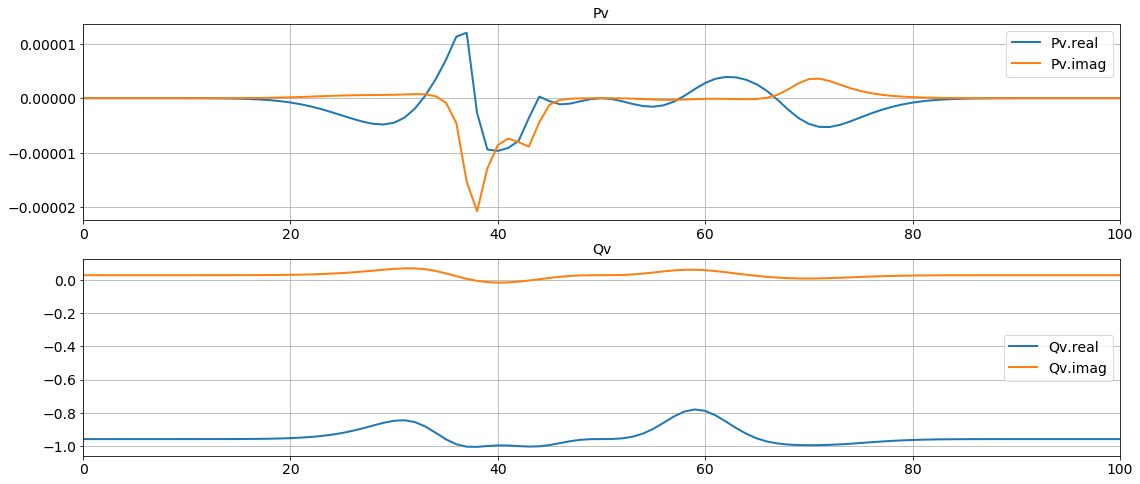

--- 5.0439465045928955 seconds ---


In [13]:
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.0 : Define an ODE solver that will use the previous functions to solve the ODE
#------------------------------------------------------------------------------------------------------------------------------
def ODE_SOLVER_REES():
    import sys
    import math
    import cmath
    import numpy as np
    import matplotlib.pyplot as plt
    import time
    
    start_time=time.time()
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.1 : Set up the grid in y, allocate memory and define the constants
#------------------------------------------------------------------------------------------------------------------------------
    Levels    = 100                 # Number of levels
    Tolerance = 1e-7                # Tolerance for errors (see Section 3.4)
    beta      = 2.2*(10**-11)       
    g         = 0.0334              # Reduced gravity
    H0        = 60                  # Average thermocline depth (see Tanaka+Hibiya)
    A0        = -1.0                # Constant for n=0
    A2        = -1.0                # Constant for n=2
    c         = np.sqrt(g*H0) 
    C         = np.sqrt((2*beta/c)) 
    
    y  = np.zeros(Levels + 2)       # Allocate memory to y
    dy = 1.0 / float(Levels)       # float/float = float   # fy = 1.0/float(Levels)
    
    for n in range(Levels + 2):
        y[n] = -10 + 20*n*dy         # y varies from -10 to 10 in Levels + 2 steps # y[n] = n*dy   
       
#-------------------------------------------------------------------------------------------------------------------------------
# Section 3.2 : Set up the values for the wave speed and wave number that we will loop over 
#-------------------------------------------------------------------------------------------------------------------------------
    cs      = np.zeros( (1,1) , dtype = np.complex) # Allocate memory for wave speed
    c_0_re  = 0.3                                  # Real part of the prescribed initial wave speed
    c_0_im  = 0.1                                  # Imaginary part of the prescribed wave speed
    c_0     = c_0_re + 1j * c_0_im                # Starting point for the wave speed (Take an educated guess)
    d_c_inc = 0.001                                 # Increment that we will add to the previous wave speed after each loop
    d_c     = d_c_inc + 1j * d_c_inc                # Since c is complex we need to make the increment complex too
    k       = 1.0                                   # Prescribed choice of wavenumber
    d_k     = 0.1                                   # Similarly, we increment over the wavenumber after each loop
    
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.3 : Find P and Q for c_0 (first choice of wave speed) and then integrate to find phi with boundary conditions
#------------------------------------------------------------------------------------------------------------------------------    
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.3.1: Begin the iteration towards a solution for wavenumber in the outer loop 
#------------------------------------------------------------------------------------------------------------------------------
# The inner loop (see Section 3.3) involves all the hard work of finding the wave speed for a given wavenumber. The outer loop
# that we start here iterates over a range of wavenumbers so that we can then find (and plot) the growth rate k*c_{i}.
    
    Max_iter_1 = 1 # We will need more than one, but start off with this as a test
    K = np.zeros(Max_iter_1) 
    for iter_outer in range(Max_iter_1):
        
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.3.2: Solving for the first choice of wave speed
#------------------------------------------------------------------------------------------------------------------------------
# This section contains the basic structure for how we solve the problem. Begin by calculating P and Q for this choice of wave
# speed. Set the boudary condition and the integrate through the domain to find each phi. Then we calculate the error at the 
# upper boundary.
        
        Pv, Qv, U, H, dUdy, dHdy, HQ, dHQdy, D, dDdy, F, dFdy, G, dGdy = P_Q_Rees(y, c_0 , k)  # Calculate P and Q for the initial choice of wavespeed

        PHI = np.zeros(Levels + 2, dtype = np.complex) # Allocate memory for phi
        PHI[0] = 0.0                                   # Boundary condition
        PHI[1] = 1.0                                   # Sets the otherwise arbitrary amplitude

        #Integrate up through the domain
        for n in range(1,Levels + 1): # Start at 1 otherwise Press[n-1] starts at Press[-1] # Also up to N_levs + 1 because y[n+1]=y[N_levs+2] which is the top of the boundary
            PHI[n+1] = INT_REES(PHI[n-1],PHI[n],Pv[n],Qv[n],y[n-1],y[n],y[n+1])

        # Calculate the error at the upper boundary
        PHI_NU_BC = PHI[Levels]
        E_0 = PHI[Levels + 1] - PHI_NU_BC  
        #print(E_0)
        
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.3 : Iterate towards a solution for the ODE over all the wave speed increments
#------------------------------------------------------------------------------------------------------------------------------  
# Now we have the same standard procedure as in the previous section but we are looping over this for different (increasingly
# accurate) wave speeds.

        #Start iterating towards a solution (i.e. increment c forwards)
        Max_iter_2 = 10      # Number of iterations,  try one as a test but will need more for an accurate c
        for iter_inner in range(Max_iter_2):
            c_1 = c_0 + d_c 
            #print(c_1)

            Pv, Qv, U, H, dUdy, dHdy, HQ, dHQdy, D, dDdy, F, dFdy, G, dGdy = P_Q_Rees(y,c_1,k) # Calculate P and Q for the new wave speed
            
            PHI = np.zeros(Levels + 2, dtype = np.complex) # Allocate memory for phi
            PHI[0] = 0.0                                   # Boundary condition
            PHI[1] = 1.0                                   # Sets the otherwise arbitrary amplitude

            #Integrate up through the domain
            for n in range(1,Levels + 1):
                PHI[n+1] = INT_REES(PHI[n-1],PHI[n],Pv[n],Qv[n],y[n-1],y[n],y[n+1]) # For c_1, find all the phi in the domain

            # Calculate the error at the upper boundary
            PHI_NU_BC = PHI[Levels]  
            E_1 = PHI[Levels + 1] - PHI_NU_BC
            #print(E_1)
            
            #c_0 = c_1
       
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.4 : Check for convergence and update the wave speed for the next loop
#------------------------------------------------------------------------------------------------------------------------------
# Here we check the convergence of the solution and update c via a shooting method and then store the final value of c in cs.
# If the solution does not converge then we break the loop and stop iterating. 


            if abs(E_1) < Tolerance:    
                if iter_inner % Levels == 0: # i_kappa % Interval_kappa == 0
                    cs[0,0] = c_1                 # Store the final value for c in cs
                    c_0 = c_1        
                    break

                # Calculate the updated values of c using a shooting method
                gradient = (c_1 - c_0)/(E_1 - E_0) 
                c_new = c_1 - gradient*E_1    

                if abs(E_1) < abs(E_0): # If absolute value of the error for c_1 is less than the old error for c_0 then,
                    c_0 = c_1           # Save c_1 if it is better than c_0
                    E_0 = E_1           # Take the least error so that we can be sure that the solution is converging

                c_1 = c_new   # Update c_1 in preperation for the next loop over wave speed
                
                

                # If the solution fails to converge for a given k then stop looping
                if abs(E_1) > Tolerance :
                    break   
            #print(gradient)        
            #print(c_1)
            
#------------------------------------------------------------------------------------------------------------------------------
# Section 3.5 : Update the wavenumber in preperation for the next loop
#------------------------------------------------------------------------------------------------------------------------------ 
        K[iter_outer] = k   # K stores the waevnumbers that we iterate over
        k = k + d_k         # Update k for the next loop
    
#------------------------------------------------------------------------------------------------------------------------------
# Section 4.0 : Plots of the results
#------------------------------------------------------------------------------------------------------------------------------
        X = 4
        i = 3            # Profile case
    #for X in range(5):   # [H,U,dHdy,dUdy] / [HQ,dHQdy,D,dDdy] / [F,dFdy,G,dGdy] / [P,Q] 
        if X == 0:
            plt.figure(figsize=(12,4))

            ax1 = plt.subplot(221)
            ax1.plot(H0+H,linewidth=2)
            ax1.set_xlim([0,Levels])
            ax1.set_title('H')
            ax1.grid()
            #ax1.xaxis.set_ticklabels([])


            ax2 = plt.subplot(222)
            ax2.plot(dHdy,linewidth=2)
            ax2.set_xlim([0,Levels])
            ax2.set_title('dHdy')
            ax2.grid()
            #ax2.xaxis.set_ticklabels([])

            ax3 = plt.subplot(223)
            ax3.plot(U,linewidth=2)
            ax3.set_xlim([0,Levels])
            ax3.set_title('U')
            ax3.grid()
            #ax3.xaxis.set_ticklabels([])

            ax4 = plt.subplot(224)
            ax4.plot(dUdy,linewidth=2)
            ax4.set_xlim([0,Levels])
            ax4.set_title('dUdy')
            ax4.grid()
            #ax4.xaxis.set_ticklabels([])

            SMALL_SIZE = 14
            MEDIUM_SIZE = 16
            BIGGER_SIZE = 22

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE) 

            plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
            plt.savefig(f'H,U,dHdy,dUdy_{i}.png',dpi=300,bbox_inches='tight')

            plt.show()
            plt.close()
        
        if X == 1:
            plt.figure(figsize=(12,4))

            ax1 = plt.subplot(211)
            ax1.plot(HQ,linewidth=2)
            ax1.set_xlim([0,Levels])
            ax1.set_title('HQ')
            ax1.grid()
            #ax1.xaxis.set_ticklabels([])


            ax2 = plt.subplot(212)
            ax2.plot(dHQdy,linewidth=2)
            ax2.set_xlim([0,Levels])
            ax2.set_title('dHQdy')
            ax2.grid()
            #ax2.xaxis.set_ticklabels([])

#            ax3 = plt.subplot(223)
#            ax3.plot(D,linewidth=2)
#            ax3.set_xlim([0,Levels])
#            ax3.set_title('D')
#            ax3.grid()
            #ax3.xaxis.set_ticklabels([])

#            ax4 = plt.subplot(224)
#            ax4.plot(dDdy,linewidth=2)
#            ax4.set_xlim([0,Levels])
#            ax4.set_title('dDdy')
#            ax4.grid()
            #ax4.xaxis.set_ticklabels([])

            SMALL_SIZE = 14
            MEDIUM_SIZE = 16
            BIGGER_SIZE = 22

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE) 

            plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
            plt.savefig(f'HQ,dHQdy_{i}.png',dpi=300,bbox_inches='tight')

            plt.show()
            plt.close()
        
        if X == 2:
            plt.figure(figsize=(12,4))

            ax1 = plt.subplot(221)
            ax1.plot(F.real,linewidth=2,label='F.real')
            ax1.plot(F.imag,linewidth=2,label='F.imag')
            ax1.set_xlim([0,Levels])
            ax1.set_title('F')
            ax1.grid()
            plt.legend()
            #ax1.xaxis.set_ticklabels([])


            ax2 = plt.subplot(222)
            ax2.plot(dFdy.real,linewidth=2,label='dFdy.real')
            ax2.plot(dFdy.imag,linewidth=2,label='dFdy.imag')
            ax2.set_xlim([0,Levels])
            ax2.set_title('dFdy')
            ax2.grid()
            plt.legend()
            #ax2.xaxis.set_ticklabels([])

            ax3 = plt.subplot(223)
            ax3.plot(G.real,linewidth=2,label='G.real')
            ax3.plot(G.imag,linewidth=2,label='G.imag')
            ax3.set_xlim([0,Levels])
            ax3.set_title('G')
            ax3.grid()
            plt.legend()
            #ax3.xaxis.set_ticklabels([])

            ax4 = plt.subplot(224)
            ax4.plot(dGdy.real,linewidth=2,label='dGdy.real')
            ax4.plot(dGdy.imag,linewidth=2,label='dGdy.imag')
            ax4.set_xlim([0,Levels])
            ax4.set_title('dGdy')
            ax4.grid()
            plt.legend()
            #ax4.xaxis.set_ticklabels([])

            SMALL_SIZE = 14
            MEDIUM_SIZE = 16
            BIGGER_SIZE = 22

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE) 

            plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
            plt.savefig(f'F,dFdy,G,dGdy_{i}.png',dpi=300,bbox_inches='tight')

            plt.show()
            plt.close()
        
        if X == 3:
            plt.figure(figsize=(12,4))

            ax1 = plt.subplot(211)
            ax1.plot(P.real,linewidth=2,label='P.real')
            ax1.plot(P.imag,linewidth=2,label='P.imag')
            ax1.set_xlim([0,Levels])
            ax1.set_title('P')
            ax1.grid()
            plt.legend()
            #ax1.xaxis.set_ticklabels([])


            ax2 = plt.subplot(212)
            ax2.plot(Q.real,linewidth=2,label='Q.real')
            ax2.plot(Q.imag,linewidth=2,label='Q.imag')
            ax2.set_xlim([0,Levels])
            ax2.set_title('Q')
            ax2.grid()
            plt.legend()
            #ax2.xaxis.set_ticklabels([])
            


            SMALL_SIZE = 14
            MEDIUM_SIZE = 16
            BIGGER_SIZE = 22

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE) 

            plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
            plt.savefig(f'P,Q_{i}.png',dpi=300,bbox_inches='tight')

            plt.show()
            plt.close()
            
        if X == 4:
            plt.figure(figsize=(12,4))

            ax1 = plt.subplot(211)
            ax1.plot(Pv.real,linewidth=2,label='Pv.real')
            ax1.plot(Pv.imag,linewidth=2,label='Pv.imag')
            ax1.set_xlim([0,Levels])
            ax1.set_title('Pv')
            ax1.grid()
            plt.legend()
            #ax1.xaxis.set_ticklabels([])


            ax2 = plt.subplot(212)
            ax2.plot(Qv.real,linewidth=2,label='Qv.real')
            ax2.plot(Qv.imag,linewidth=2,label='Qv.imag')
            ax2.set_xlim([0,Levels])
            ax2.set_title('Qv')
            ax2.grid()
            plt.legend()
            #ax2.xaxis.set_ticklabels([])
            


            SMALL_SIZE = 14
            MEDIUM_SIZE = 16
            BIGGER_SIZE = 22

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE) 

            plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
            plt.savefig(f'Pv,Qv_{i}.png',dpi=300,bbox_inches='tight')

            plt.show()
            plt.close()
        
    #plt.plot(PHI)
    #plt.title('Phi(n)')
    #plt.xlabel('Levels (n)')
    #plt.xlim(0,Levels)
    #plt.grid()
    #plt.savefig(f'Phi.png',dpi=300,bbox_inches='tight')
    #plt.show()
        

#--------------------------------------------------------------------------------------------------------------------------
# Section 5.0 : Time taken for the code to run
#--------------------------------------------------------------------------------------------------------------------------
    print("--- %s seconds ---" % (time.time() - start_time))
ODE_SOLVER_REES()

In [ ]:
#-----Plotting pngs of F to then use ffmpeg to get an animation---------
#print("%04d" %(iter_inner))
#FIG=plt.figure()
#ax=plt.gca()
#plt.plot(F.real,linewidth=2,label='F.real')
#plt.plot(F.imag,linewidth=2,label='F.imag')
#plt.xlim(0,Levels)
#plt.ylim(-0.25,0.15)
#plt.title('F_%04d' %(iter_inner))
#plt.grid()
#plt.legend(loc='best')
#plt.savefig('F_%04d.png' %(iter_inner),dpi=300,bbox_inches='tight')
#plt.close(FIG)